<a href="https://colab.research.google.com/github/lgiesen/forest-height/blob/CNN/forest_height.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forest Height Estimation
Objective of this notebook:
- Train model
- Evaluate model
- Export model for prediction

Prerequisite:
- Training data is generated in [data_exploration.ipynb](https://github.com/lgiesen/forest-height/blob/main/data_exploration.ipynb)
- Prediction of the dataset is realized in a python file (!to be created), but it is tested in a Jupyter Notebook (!to be created)

### To Dos

- Data Augmentation (flip image at least by 90, 180 and 270°)
- rename `preds` to `preds_<approach>` -> compare predictions in one overview (also good for poster)
- export predictions to file
- split this notebook into several ones. One for dataset generation, one for loading dataset, one for each approach generating a model (+ export performance KPIs) and one conclusion notebook to compare approaches (loads performance KPIs)

### Tasks from Presentation
- Split the dataset into a training and validation set. Train a first regression model on the provided training dataset.
- Try out different architectures, hyperparameter.
- Now, you are supposed to apply your model to the test set. First, you have to
implement the sliding window approach in combination with non-max suppression. Note: Instead of choosing the non-max suppression, you can choose a different
approach or come up with your own.
- After you have found your best performing setup, apply your model to the unlabeled data set. You can check for plausibility by visually inspecting the output or choose to reuse the predictions for increasing the number of training observations.

- implement 1 ML Model (Logistic Regression, Boosted Trees, Random Forest, ...) and one CNN Model -> compare them in a poster (I'd use Figma as a tool)
- submission: script that produces a binary output numpy-file (.npy) for every test image, automatically.


### Submission
- The npy-files should have the same height and width as the original satellite image. Your submission should therefore be a zip file containing multiple npy-files of size [1 × width × weight]
- We will use the Mean Absolute Error (MAE) to measure your performance on the hidden test set. For this, we will provide further information at a later time.
- Deadline: 4th July, 11:59pm

- ZIP-file with all the predictions as described above
- ZIP-file with your source code (only the files that are used in your final product)
- A poster (A1-size) as pdf-file

In [2]:
from google.colab import drive
drive.mount ('/content/drive', force_remount=True)
root_path = 'drive/MyDrive/Colab Notebooks/data/'

Mounted at /content/drive


In [3]:

path_images = f'{root_path}images/'
path_masks = f'{root_path}masks/'

In [4]:
def path_exists(path):
  import os
  return os.path.exists(root_path + path)

In [5]:
import numpy as np
# load exemplary data
sat_path = 'images/image_004.npy'
if path_exists(sat_path):
  satellite = np.load(root_path + sat_path)
  print('satellite:',satellite.shape)
mask_path = 'masks/mask_004.npy'
if path_exists(mask_path):
  mask = np.load(root_path + mask_path)
  mask.shape
  print('mask:',satellite.shape)

satellite: (10, 1024, 1024)
mask: (10, 1024, 1024)


In [6]:
print(satellite)

[[[ 406  384  399 ...  311  386  386]
  [ 394  384  395 ...  332  347  340]
  [ 392  389  402 ...  361  343  316]
  ...
  [ 185  170  169 ...  209  204  188]
  [ 173  179  189 ...  198  202  214]
  [ 168  161  185 ...  168  202  209]]

 [[ 421  414  425 ...  566  626  624]
  [ 418  414  410 ...  582  601  604]
  [ 422  422  412 ...  607  608  578]
  ...
  [ 304  276  273 ...  322  345  281]
  [ 335  293  314 ...  317  329  334]
  [ 295  273  319 ...  279  334  337]]

 [[ 134  141  139 ...  406  558  547]
  [ 140  139  130 ...  442  488  460]
  [ 140  134  138 ...  516  472  414]
  ...
  [ 177  153  161 ...  181  189  170]
  [ 180  182  181 ...  178  191  193]
  [ 162  160  170 ...  169  186  189]]

 ...

 [[  92   86   84 ... 3024 3034 3034]
  [  92   86   83 ... 3024 3034 3034]
  [  95   88   82 ... 3260 3126 3126]
  ...
  [2411 2411 2662 ... 2466 2501 2371]
  [2508 2508 2892 ... 2489 2537 2692]
  [2657 2657 3208 ... 2437 2537 2537]]

 [[  38   33   35 ... 1817 1805 1805]
  [  38   33

In [7]:
import matplotlib.pyplot as plt
def plot_img(img, is_satellite = True):
    #shape: satellite == (10, 1024, 1024), mask == (1, 1024, 1024)
    if is_satellite:
      # Extract Red, Green, and Blue bands
      red = img[2, :, :]
      green = img[1, :, :]
      blue = img[0, :, :]

      # Normalize the bands to [0, 1] range
      red_norm = (red - red.min()) / (red.max() - red.min())
      green_norm = (green - green.min()) / (green.max() - green.min())
      blue_norm = (blue - blue.min()) / (blue.max() - blue.min())

      # Stack the bands to create an RGB image
      scaled_img = np.stack((red_norm, green_norm, blue_norm), axis=-1)

    elif not is_satellite:
      scaled_img = (mask - np.min(mask)) / (np.amax(mask) - np.amin(mask))
      # TODO: scale with total max and min of all masks for comparability
      scaled_img = np.squeeze(scaled_img) # remove redundant dimension


    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(scaled_img)
    plt.axis('off')
    plt.show()

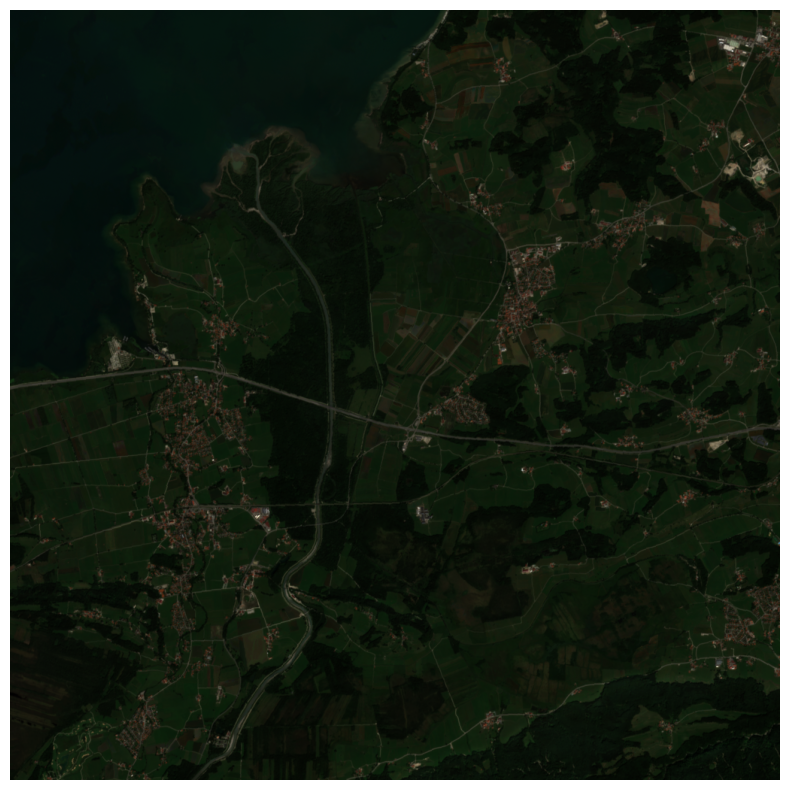

In [8]:
plot_img(satellite)

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Preparation

The npy files are combined into a dataset. After the first loading they do not have to be generated anymore.
One npy file might need to be split into smaller images of 256x256 or 512x512 pixels, which then are put back together in the end.

In [10]:
# load dataset
path_train_sat = f"{root_path}train_satellite.npy"
path_train_masks = f"{root_path}train_masks.npy"

X = np.load(path_train_sat, allow_pickle=True)
y = np.load(path_train_masks, allow_pickle=True)

In [11]:
# remove drive connection as it is no longer needed
drive.flush_and_unmount()

In [12]:
from sklearn.model_selection import train_test_split
# split dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

In [13]:
print(X_train.shape)
print(X_test.shape)

(16, 10, 1024, 1024)
(4, 10, 1024, 1024)


## Training

### Machine Learning Regressor



Suggestions based on [SciKits advice](https://scikit-learn.org/stable/_static/ml_map.png) on choosing the right model:
- RidgeRegression
- SVR(kernel='linear')
- SVR(kernel='rbf')
- EnsembleRegressors

Random Forest Tipps from Lecture:

1. Trees & Arrays: Each tree is stored in an array (low-level, C-like)
2. Sorting: Optimized sorting algorithm (standard qsort → factor 2-3 slower)
3. Locally constant features: Keep track of “constant” features during construction.
4. Unique instances: If bootstrap=True, only use unique indices/patterns (only 63%) and assign weights to them → Speed-up of about 1.5!
5. Consecutive memory access: For evaluating O(S), prefetch data for dimension i
6. Sparse data: Make use of optimized computations for sparse data.
7. Random numbers: Use manual random number generator . . .
8. Parallelization: For random forests, efficient parallelization over trees.

#### Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# instantiate the model
# TODO: Try out different values for min_samples_split
# corresponds to "m" in the slides
min_samples_split = 2

# instantiate model and fit it!
model = DecisionTreeRegressor(max_depth=5, min_samples_split=min_samples_split)

In [ ]:
def reshape_2D(var):
  if len(var.shape) == 4:
    nsamples, color_channel, nx, ny = var.shape
  else:
    nsamples, nx, ny = var.shape
    color_channel = 1
  return var.reshape((nsamples, color_channel*nx*ny))

In [ ]:
# reshape data so that DecisionTreeRegressor can work with the data
X_train_2D = reshape_2D(X_train).tolist()
y_train_2D = reshape_2D(y_train).tolist()

> Try out df as a data format. Previously tried out: ndarray, list

> Use k-fold cross-validation for hyperparameter tuning of `max_depth`

In [ ]:
del X, y

In [ ]:
%%time
# train the model
model.fit(X_train_2D, y_train_2D)
#model_2.fit(X_train_2D, y_train_2D)

In [ ]:
from sklearn.model_selection import GridSearchCV
# k-fold cross-validation for hyperparameter tuning of max_depth
gs = GridSearchCV(model,
                  param_grid = {'max_depth': range(1, 11),
                                'min_samples_split': range(10, 60, 10)},
                  cv=5,r
                  n_jobs=1,
                  scoring='neg_mean_squared_error')

gs.fit(X_train, y_train) # X_train_2D, y_train_2D

print(gs.best_params_)
print(-gs.best_score_)

In [ ]:
# Predict
# X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
X_test_2D = reshape_2D(X_test).tolist()
y_test_2D = reshape_2D(y_test).tolist()
preds = model.predict(X_test_2D)
#preds_model_2 = model_2.predict(y_test_2D)

In [ ]:
model.summary()

In [ ]:
# save the model to disk
import pickle
path_reg_model = root_path + 'DecisionTreeRegressor.sav'
pickle.dump(model, open(path_reg_model, 'wb'))
# loaded_model = pickle.load(open(path_reg_model, 'rb'))

In [ ]:
# save the model to disk
import pickle
from sklearn.externals import joblib
path_reg_model = root_path +  "DecisionTreeRegressor.joblib"
joblib.dump(model, path_reg_model)
# loaded_model = joblib.load(path_reg_model)

In [ ]:
# Plot the results
plt.figure()
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test_2D, y_test_2D, color="cornflowerblue", label="max_depth=2", linewidth=2)
plt.plot(X_test_2D, y_test_2D, color="yellowgreen", label="max_depth=5", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

# from the Lecture:
X_plot = np.arange(0.0, 5.0, 0.01).reshape((-1,1))
plt.figure(figsize=(10,6))
plt.scatter(X, y, c="darkorange", label="Data", s=25)
plt.plot(X_plot, preds, color="cornflowerblue", label="Model", linewidth=3)
plt.xlabel("X", fontsize=18)
plt.ylabel("Y", fontsize=18)
plt.title(f"Regression Tree (m={min_samples_split})", fontsize=16)
plt.legend()

#
sns.scatterplot(x=df['Longitude'],
                y=df['MedHouseVal'],
                label='data')

plt.plot(df['Longitude'].sort_values(),
         dtr1.predict(df['Longitude'].sort_values().to_frame()),
         color='red', label='model',
         linewidth=2)

plt.legend()

plt.savefig('model.png')

In [ ]:
# visualize tree
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(dtr1, feature_names=['Longitude'],
                           filled=True, rounded=True)

graph = graphviz.Source(dot_data)
graph.render("tree")

Visualize Decision Tree: https://towardsdatascience.com/visualizing-decision-trees-with-python-scikit-learn-graphviz-matplotlib-1c50b4aa68dc

In [ ]:
# Evaluate Decision Tree Regressor
loss, acc = model.evaluate(X_test_2D, y_test_2D, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

#### Random Forest Regression
https://towardsdatascience.com/machine-learning-basics-random-forest-regression-be3e1e3bb91a

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# initialize model
model = RandomForestRegressor(n_estimators=100)
# train model
model.fit(X_train, y_train)

In [ ]:
# predict values
preds = model.predict(X_test)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

from sklearn.metrics import mean_squared_error

# compute RMSE
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_test, preds))))

# visualize predictions vs. true labels
fig = plt.figure(figsize=(8,8))
plt.scatter(preds, y_test, color="blue", alpha=0.5)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.plot([-100000,600000], [-100000, 600000], 'k--')
plt.xlabel("Predictions")
plt.ylabel("True Labels")
plt.xlim([-100000,600000])
plt.ylim([-100000,600000])
plt.title("Evaluation of Random Forest Regression Model")
plt.show()

#### Support Vector Regression

https://towardsdatascience.com/machine-learning-basics-support-vector-regression-660306ac5226

### Convolutional Neural Network (CNN)

In [14]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Evaluation

In [15]:
from keras.engine.input_layer import InputLayer
import tensorflow as tf
from tensorflow.keras import layers

# Define the CNN model architecture
model = tf.keras.Sequential()

# Add convolutional layers
model.add(InputLayer(input_shape=(10, 1024, 1024)))
model.add(layers.Conv2D(filters=10, kernel_size=(3, 3),strides=1, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))


# Flatten the output and add dense layers
model.add(layers.Flatten())
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(20, activation='softmax'))
model.add(layers.Dense(1))  # The output layer with a single neuron for height prediction

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['categorical_accuracy'])

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 10, 1024, 10)      92170     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5, 512, 10)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 25600)             0         
                                                                 
 dense (Dense)               (None, 30)                768030    
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 dense_2 (Dense)             (None, 20)                620       
                                                        

In [ ]:
history = model.fit(X_train,
                    y_train,
                    epochs=15,
                    batch_size=64,
                    validation_split=0.1)

Epoch 1/15
